In [2]:
# install.packages("partykit")
# install.packages("pre")
library("partykit")
source("SimData.r")
library("party")
library(MASS)
library("glmertree")
library("caret") # importance and rfe
source("SimData.r")
library("randomForest")
library("rpart")
library("fuzzyforest")
library("WGCNA")
library("pre")
library(REEMtree)

# data

In [14]:
# training data
n <- 200 # number of patients
T <-  5 # number of observations per patients

set.seed(100)

data <- sim_quad(n,T)


#add PC
data$PC1 = (prcomp(data[,1:100], scale = TRUE)$x)[,1]
# data$PC1 = scale(data$PC1)/norm(scale(data$PC1),type="2")
data$PC2 = (prcomp(data[,101:200], scale = TRUE)$x)[,1]
data$PC3 = (prcomp(data[,201:300], scale = TRUE)$x)[,1]

# add time_squared
data$time2 = (data$time)^2

# # add group*time interaction
# data$time_G1 = data$time * data$group1 # b1, time*group1
# data$time_G2 = data$time * data$group2 # b2
# data$time2_G1 = (data$time)^2 * data$group1 # b1 time^2 * group1
# data$time2_G2 = (data$time)^2 * data$group2 # b2


head(data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V400,rand_int,time,treatment,patient,y,PC1,PC2,PC3,time2
-0.7525122,-1.3009301,-1.5954308,-1.3213033,-1.1487995,-2.031498212,-1.5819936,-1.1953649,-1.07847035,-0.91618527,...,-0.0749961081,-0.1793452,1,1,1,25.68078,-11.739811,-9.954090,-4.5407021,1
1.3467494,0.1496223,-0.5085007,1.2139482,0.4379413,0.004003182,0.2903688,0.1238891,-0.06029441,0.16995472,...,-0.9470827924,-0.1793452,2,1,1,16.85840,1.847209,-10.700730,1.0096097,4
1.2063365,1.3671147,1.7662599,1.9387756,1.6007378,1.762405447,1.8650487,1.1637020,1.06221789,1.89661535,...,0.0003758095,-0.1793452,3,1,1,22.68817,14.788977,-5.299017,-0.8355472,9
0.2455117,1.2522890,1.0908024,0.5464719,0.7927801,0.916179556,0.9042531,0.1331823,1.22958212,0.02031135,...,-1.5249574007,-0.1793452,4,1,1,20.00243,5.265443,-9.761230,7.6165008,16
0.1536956,0.1154021,0.5989087,0.7043994,0.1675861,-0.688508369,-0.1574930,1.0713512,0.41732400,-0.22136912,...,0.0983516474,-0.1793452,5,1,1,29.71697,1.941331,-10.304537,0.8757511,25
-0.1235380,1.4273943,1.5391849,0.2571678,1.1143623,1.253610442,1.8531652,1.4823350,1.41079955,1.84109519,...,-1.5266078213,0.9853723,1,1,2,46.12282,11.383983,-6.879353,2.6413567,1


In [15]:
# testing data
n_test <- 100 # number of patients
T <-  5 # number of observations per patients

set.seed(101)

data_test <- sim_quad(n_test, T)


#add PC: only for testing; In our final algorithm we don't need PC of test data
data_test$PC1 = (prcomp(data_test[,1:100], scale = TRUE)$x)[,1]
# data$PC1 = scale(data$PC1)/norm(scale(data$PC1),type="2")
data_test$PC2 = (prcomp(data_test[,101:200], scale = TRUE)$x)[,1]
data_test$PC3 = (prcomp(data_test[,201:300], scale = TRUE)$x)[,1]

# add time_squared
data_test$time2 = (data_test$time)^2

# add group*time interaction
# data_test$time_G1 = data_test$time * data_test$group1 # b1, time*group1
# data_test$time_G2 = data_test$time * data_test$group2 # b2
# data_test$time2_G1 = (data_test$time)^2 * data_test$group1 # b1 time^2 * group1
# data_test$time2_G2 = (data_test$time)^2 * data_test$group2 # b2

head(data_test)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V400,rand_int,time,treatment,patient,y,PC1,PC2,PC3,time2
-0.1794102,-0.7293793,-0.5451425,-0.6759157,-0.69938339,-0.7425785,-0.36740919,-0.05614226,-0.4689813,-0.9957741,...,0.04467189,0.9913158,1,1,1,17.982681,-4.052595,-11.7896739,-2.429686,1
0.8907442,2.0446333,2.2867130,1.9176666,1.18491329,1.4608648,1.57879314,1.51672880,1.4702505,1.8208692,...,0.56829129,0.9913158,2,1,1,39.950832,18.372992,-6.1072477,5.657972,4
0.2463468,-0.3266239,-0.1396596,-0.1119510,0.39615391,0.7130694,-0.56640362,0.43538748,0.3228802,0.1798426,...,-0.61422493,0.9913158,3,1,1,-2.840054,1.099723,-2.7001757,-5.626646,9
-0.6415846,-0.1170245,-1.2137791,-1.4818147,-1.02402806,-0.8341220,-0.92867891,-0.63758937,-1.6522012,-1.5747861,...,0.56752086,0.9913158,4,1,1,-5.957963,-8.471346,-5.2856326,2.560440,16
-1.2865155,0.1642321,0.6040035,-0.2489238,-0.39677846,0.3232312,0.02991788,-0.93041047,-0.5375453,0.2817597,...,0.18072176,0.9913158,5,1,1,11.513002,0.974368,-0.1528867,3.451664,25
0.6467019,-0.6255761,0.4649954,0.4595883,0.08918262,-0.4334162,0.08811692,0.20140550,0.1705507,-0.2342035,...,-3.27472578,0.6967010,1,1,2,19.294548,2.479159,2.4828303,11.382378,1


In [16]:
# Methods for extracting names of splitting features used in a tree
# tree: a tree object; data: the train or test set
get_split_names = function(tree,data){
    # path: the string that contains all the node information
    paths <- pre:::list.rules(tree, removecomplements = FALSE)
    vnames = names(data)
    # the regex for a variable
    # tomatch = paste(paste(var,"<="),"|",paste(var,">"),sep="")
    # match to tomatch in path
    tmp = vnames[sapply(sapply(vnames, FUN = function(var) grep(paste(paste(var,"<="),"|",paste(var,">"),sep=""), paths)), length) > 0]
    return (tmp)
}

If use model REEM tree on this data directly, without WGCNA: It loses features from the independent groups

In [31]:
# The most naive way
split_var = c(paste("V",1:400,sep=""),"treatment")
regress_var = c("time2","time")
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|","patient","|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
get_split_names(mytree$tree,data)
mean((predict(mytree,newdata=data_test)-data_test$y)**2)

[1] "V1"   "V2"   "V3"   "V14"  "V26"  "V80"  "V301"

[1] 81.68358

In [32]:
# If we select feature and put them in split_var too
final_var = paste("V",c(1,2,3,14,26,80,301),sep="")
# use the final features as split&regression variables
split_var = c(final_var,"treatment")
regress_var = c("time2","time",final_var)
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|","patient","|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
get_split_names(mytree$tree,data)
mean((predict(mytree,newdata=data_test)-data_test$y)**2)

[1] "V2"  "V3"  "V26"

[1] 42.00903

# Automatic version

In [17]:
start_time <- Sys.time()

data_WGCNA = data[,1:400] # only the covariates
# choose power = 6, which is not quite correct
# Please set numericLabels = FALSE so that the label is one color (string)
# if verbose = 3, show some details
net = blockwiseModules(data_WGCNA, power = 6,TOMType = "unsigned", 
                       minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = FALSE, 
                       pamRespectsDendro = FALSE,verbose = 0)

# the correspondance betweeen feature names and colors
colors = net$colors # it is a string vector with names (that is the name is V1)
# Get a list with the first element being all the names of first groups and so on
# all the names of modules
module_names = unique(colors) # all colors name

# a vector with name(index) = names of modules and value = the corresponding names
# of features (like a dictionary)
module_dic = list()
for (i in 1:length(module_names)){
    module_dic[[module_names[i]]] = names(colors[colors==module_names[i]])
}
# module_dic

In [18]:
##### eigengene: here we may not need this since we have time as regressor ####
# # extract eigengenes and rename the column.
# # The eigengene(1st pricinpal component) is L2 normalized
# eigengene = net$MEs
# # eigengene
# # add eigengen to training data
# for (name in module_names){
#     if (name == "grey"){
#         next
#     }
#     eigen_name = paste("ME",name,sep="")
#     data[[eigen_name]] = eigengene[[eigen_name]]
# }
# # head(data)
##### end eigengene ####

In [19]:
imp_var = list() # used to store the names of important features
cluster_var = "patient" # the name should be specified by the users

# For each module including grey, use model tree as following:
# use its time and time2 as regression variables
# use all features in the module + treatment as splitting variables
# Finally, use all the chosen features for splitting and regression variables

# for non-grey groups
for (name in module_names){
    
    # in the formula, add treatment as split_var, also include the module features
    split_var = c(module_dic[[name]],"treatment")
    
    # use time and time2 as regressor
    regress_var = c("time2","time")
    
    # Formula for lmtree: use PC as regressors
    Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                paste(split_var,collapse = "+")))
    
    # fit the tree
    mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
    
    #extract important features
    imp_var[[length(imp_var)+1]] = get_split_names(mytree$tree,data)
    
#     plot(mytree)
#     flush.console()
#     cat("\n",get_split_names(mytree$tree,data),"\n")
    # to print the error, we have to add PC to test data
#     print(mean((predict(mytree,newdata=data_test)-data_test$y)**2))
}


imp_var 

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular


[[1]]
[1] "V1"  "V2"  "V3"  "V13" "V22" "V68"

[[2]]
character(0)

[[3]]
character(0)

[[4]]
[1] "V301" "V303"

In [20]:
# the variables selected from all the modules
final_var = imp_var[[1]]
if (length(imp_var)>1){
    for (i in 2:length(imp_var)){
    final_var = c(final_var,imp_var[[i]])
 }
}
final_var

[1] "V1"   "V2"   "V3"   "V13"  "V22"  "V68"  "V301" "V303"

In [21]:
# the final selection among all the chosen features 
regress_var = c("time2","time")
split_var = c(final_var,"treatment")
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=8) 
final_var = get_split_names(mytree$tree,data)
final_var

[1] "V1"   "V2"   "V3"   "V13"  "V22"  "V68"  "V301" "V303"

In [22]:
# final_var = paste("V",c(1,2,3,301,302,303),sep="") # if cheating

In [23]:
# use the final features as split&regression variables
split_var = c(final_var,"treatment")
regress_var = c("time2","time",final_var)
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 

Time difference of 15.70953 secs

[1] 39.74423

$patient


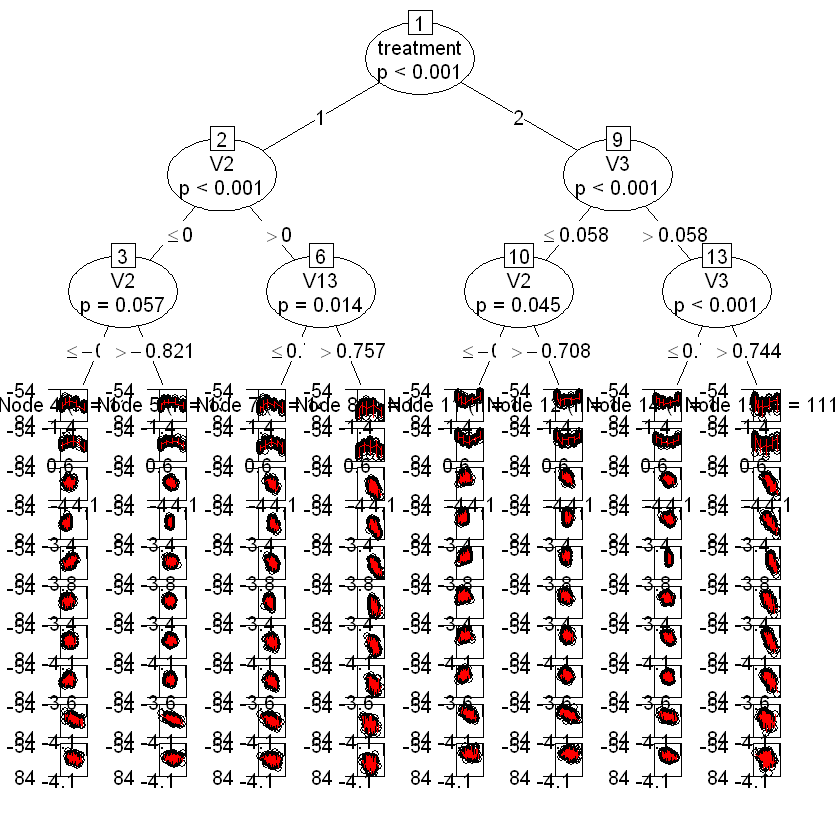

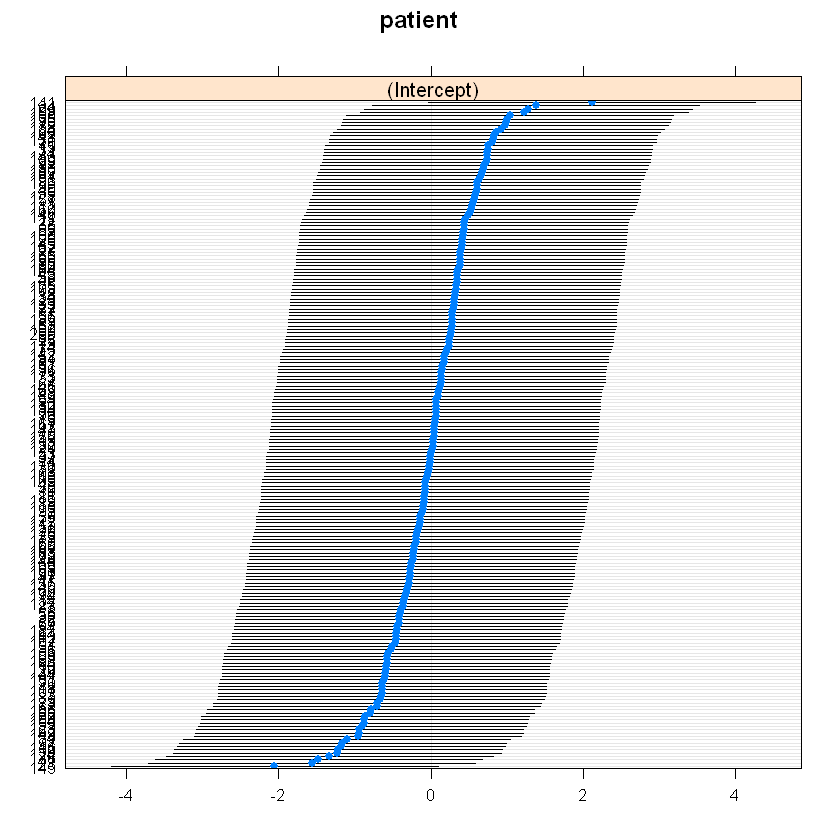

In [24]:
end_time <- Sys.time()
end_time - start_time # running time

mean((predict(mytree,newdata=data_test)-data_test$y)**2)
plot(mytree)

In [25]:
coef(mytree)

,(Intercept),time2,time,V1,V2,V3,V13,V22,V68,V301,V303
4,34.54111,4.886023,-29.25761,3.798234,-6.698916,-5.1146613,-0.4384340,3.82130484,-1.13967710,5.330209,1.305492
5,41.21406,4.780231,-28.60833,4.160007,-1.886795,-0.6239433,0.3072264,-0.30547772,-0.09986067,4.623576,1.053775
7,44.70001,5.137619,-30.83944,5.598557,5.287817,3.4201778,0.7478512,-0.27333752,-0.56816910,4.979449,1.241307
8,43.42821,5.743171,-34.57631,5.215773,7.864113,11.2514227,-0.5102950,1.10789397,-2.45805127,4.953191,3.249709
11,-56.49109,-5.178971,30.78234,4.320199,-5.742974,-6.0566980,1.6615713,0.68626971,-1.02060754,5.331632,1.439171
12,-45.56877,-5.161528,30.43438,5.294826,-1.431948,-2.0179606,0.8563530,1.25748365,0.52724894,4.543242,1.191853
14,-42.48134,-4.455033,27.14678,3.011768,2.786672,6.0636405,-1.2957589,1.31529746,1.41752731,4.830919,2.199437
15,-56.82164,-4.986914,30.64594,3.546544,8.618219,10.7279041,1.8568018,-0.04282177,-0.44470274,5.503159,2.866828


# Model tree: step by step version

In [21]:
# split_var = c("treatment",paste("V",301:400,sep=""))
# split_var = c("treatment")
# split_var = c("treatment",paste("V",c(1,2,3,301,302,303),sep=""))
# split_var = c("treatment",paste("V",c(1,2,3,301,302,303),sep="")) # correct

# regress_var = c("time2","time")
# regress_var = c("V1")
regress_var = c("time","time2")
# regress_var = c("time2","time",paste("V",c(1,2,3),sep=""))

cluster_var = "patient"
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
# Formula

system.time({
    # you can change alpha = 0.2
    lmm_tree <- lmertree(Formula, data = data,alpha = 0.2,maxdepth=4) 
})
# mean square error on test data
mean((predict(lmm_tree,newdata=data_test,re.form=NA)-data_test$y)**2)

# the selected features
get_split_names(lmm_tree$tree,data)

# coef(lmm_tree)
# plot(lmm_tree,which="tree",main = "glmertree")

   user  system elapsed 
   5.25    0.04    5.56 

[1] 94.56116

[1] "V1" "V2" "V3"

In [43]:
coef(lmm_tree)

,(Intercept),time,time2
5,40.99118,-31.895063,5.182074
6,44.33446,-29.283495,4.927686
8,48.76405,-29.716642,4.888221
9,57.95539,-31.696468,5.331493
12,54.18950,-28.757700,4.930032
13,59.97979,-21.679963,3.417342
14,91.13816,-36.518382,5.665010
18,-56.45577,33.079386,-5.436157
19,-40.96788,28.767228,-4.876719
21,-44.44926,30.595360,-5.067669


In [16]:
# random effect (here is just intercept)
# ranef(lmm_tree)

# Benchmark

## Fuzzy Forest

   user  system elapsed 
 626.13    2.11  635.48 

[1] 50.01623

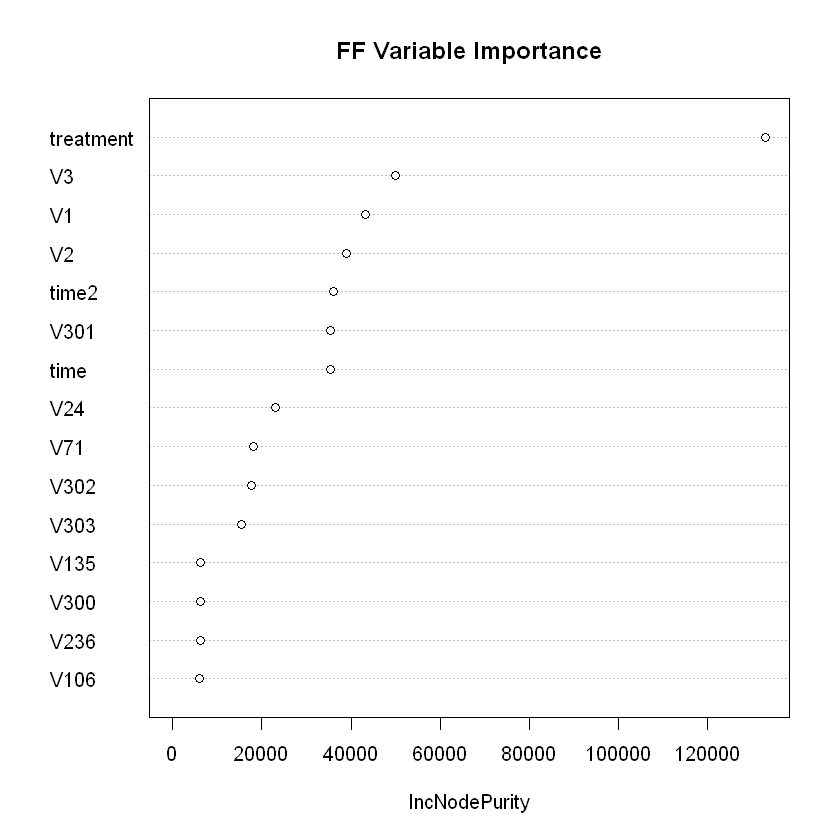

In [17]:
# since treatment is categorical, we cannot include it in WGCNA
system.time({
data_WGCNA = data[,1:400] # only the covariates
# choose power = 6, which is not quite correct
# Please set numericLabels = FALSE so that the label is one color (string)
# if verbose = 3, show some details
net = blockwiseModules(data_WGCNA, power = 6,TOMType = "unsigned", 
                       minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = FALSE, 
                       pamRespectsDendro = FALSE,verbose = 0)

var = c(paste("V",1:400,sep=""),"time","time2","treatment")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))
    
net$colors[["time"]] = "grey"
net$colors[["time2"]] = "grey"
net$colors[["treatment"]] = "grey"
    
# var = paste("V",1:400,sep="")
# Formula = as.formula(paste("y~",paste(var,collapse = "+")))
    


ff_fit = ff(Formula,data = data,module_membership=net$colors,
        screen_params = screen_control(min_ntree = 500),
        select_params = select_control(min_ntree = 500,number_selected = 15), 
        final_ntree = 5000, num_processors = 1)        
})
mean((predict(ff_fit,new_data=data_test)-data_test$y)**2)
varImpPlot(ff_fit$final_rf,type=2,main="FF Variable Importance")

## Random Forest

   user  system elapsed 
  84.43    0.41   86.08 

[1] 76.7205

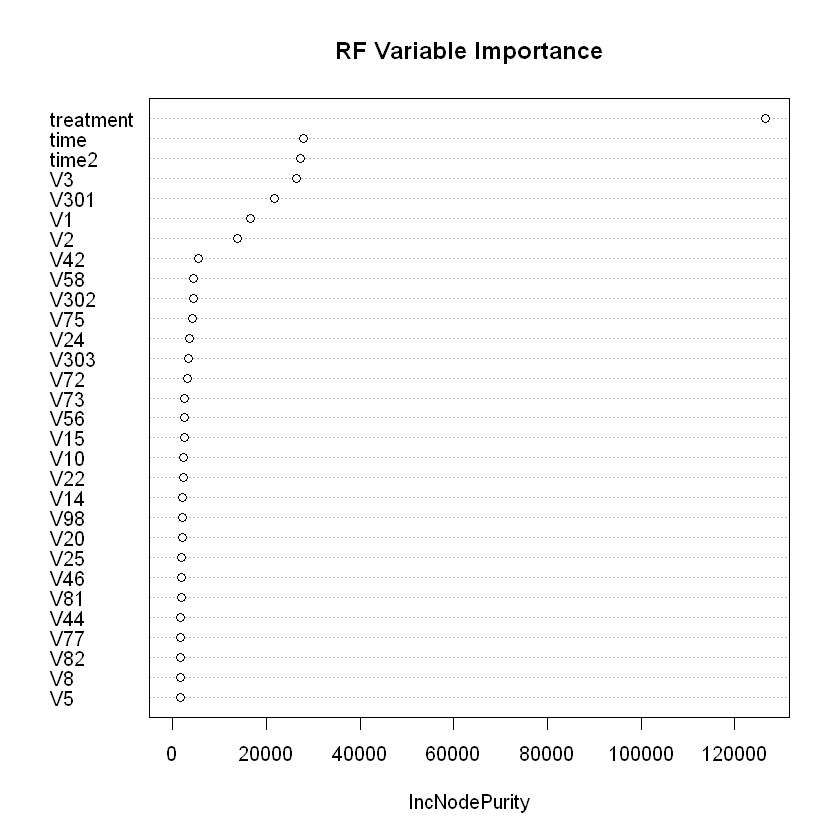

In [23]:
# Random Forest
var = c(paste("V",1:400,sep=""),"time","time2","treatment")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))
system.time({
#     set.seed(20)
    rf <- randomForest(Formula,data)
})
mean((predict(rf,newdata=data_test)-data_test$y)**2)
varImpPlot(rf,type=2,main="RF Variable Importance")

## RE-EM tree

   user  system elapsed 
   5.56    0.11    5.79 

treatment      time     time2        V3        V2       V73      V301       V70 
146623.11  84411.47  84411.47  55594.95  37365.49  30098.77  22372.31  22203.33 
      V15       V82       V62        V5       V99       V24       V25 
 21932.52  21215.48  17794.24  17584.89  16135.10  15568.95  15568.95

[1] 108.8273

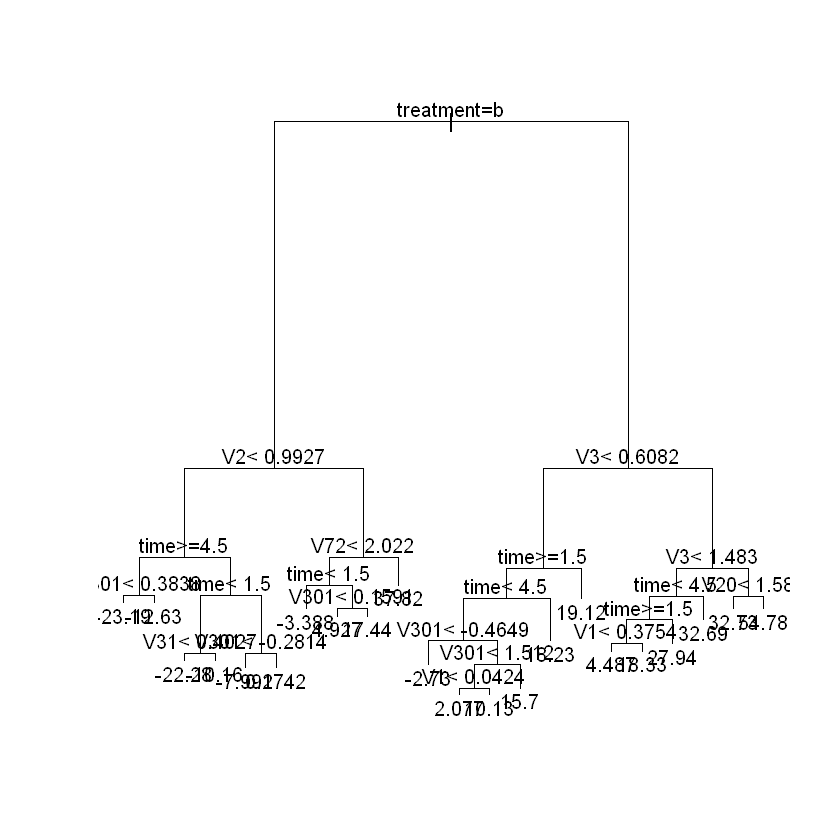

In [19]:
variables = c(paste("V",1:400,sep=""),"treatment","time","time2")
Formular = as.formula(paste("y~",paste(variables,collapse = "+")))
system.time({REEMresult<-REEMtree(Formular, data=data, random=~1|patient)})
sort(REEMresult$Tree$variable.importance, decreasing = TRUE)[1:15]
mean((predict(REEMresult,newdata=data_test,EstimateRandomEffects=FALSE)-
      data_test$y)**2)
plot(REEMresult)